# Gauge Observables

--------------------------------------------------------------------
### TODO:
* [x] Generate multiple chain lengths and deal with loading in from multiple `samples_history` files.
* [x] Implement the same logic for `observables` as for `samples_history`.
* [x] Modify remainder of code below to deal with case where `samples` and `observables` are dictionaries with keys specifying the length of the MCMC chain.
* [x] Re-run the cells below for the remainder of `HMC` directory to get ESS values for comparing against ESS from L2HMC.
* [x] Try training sampler for >> 1000 steps and running the trained sampler for a variety of different chain lengths to see what the integrated autocorrelation time approaches as  $N_{steps} \longrightarrow \infty$.
--------------------------------------------------------------------

In [1]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import autocorrelation_plot
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
COLORS = 5 * ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = 5 * ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'P', 'D']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

tf.enable_eager_execution()
tfe = tf.contrib.eager

In [10]:
from lattice.lattice import GaugeLattice, u1_plaq_exact
#from l2hmc_eager import gauge_dynamics_eager as gde
from gauge_model import GaugeModel
from utils.file_io import save_params_to_pkl_file
from utils.observables import Observables

import utils.gauge_model_helpers as helpers
from utils.autocorr import *
from utils.gauge_observables import *
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

%autoreload 2
%matplotlib inline

## Helper functions

In [11]:
def check_else_make_dir(d):
    if not os.path.isdir(d):
        print(f"Making directory: {d}")
        os.makedirs(d)
        
def plot_individual_observables(figs_dir, observables, top_charges_autocorr):
    multiple_lines_figs_axes = make_multiple_lines_plots(
        figs_dir,
        params['beta_final'],
        observables,
        top_charges_autocorr,
        legend=False
    )
    return multiple_lines_figs_axes

def plot_individual_acf_iat(acf_arr, iat_arr, ess_arr, figs_dir):
    out_file = os.path.join(
        figs_dir, 
        'integrated_autocorrelation_time_plot.pdf'
    )
    kwargs = {
        'x_label': 'Lag',
        'y_label': 'Autocorrelation (top. charge)',
        'legend': True,
        'out_file': out_file
    }
    fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ess_arr, **kwargs)
    
    return fig, ax
        

## Observables analysis

### Helper functions

In [12]:
def load_stats_and_observables(d):
    """Load actions, plaqs. and top. charges from `.pkl` files in dir `d`."""
    actions_file = [
        os.path.join(d, i) for i in os.listdir(d) 
        if i.startswith('actions_steps') and i.endswith('.pkl')
    ]
    plaqs_file = [
        os.path.join(d, i) for i in os.listdir(d) 
        if i.startswith('plaqs_steps') and i.endswith('.pkl')
    ]
    charges_file = [
        os.path.join(d, i) for i in os.listdir(d) 
        if i.startswith('charges_steps') and i.endswith('.pkl')
    ]
    tun_events_file = [
        os.path.join(d, i) for i in os.listdir(d)
        if i.startswith('tunn_events') and i.endswith('.pkl')
    ]
    with open(actions_file[0], 'rb') as f:
        actions_dict = pickle.load(f)
    with open(plaqs_file[0], 'rb') as f:
        plaqs_dict = pickle.load(f)
    with open(charges_file[0], 'rb') as f:
        charges_dict = pickle.load(f)
    with open(tun_events_file[0], 'rb') as f:
        tun_events = pickle.load(f)
        
    return actions_dict, plaqs_dict, charges_dict, tun_events

In [ ]:
def plot_observables(observables, current_step=None):
    """Plot observables stored in `observables`.
    
    Args:
        observables: Tuple of (actions_dict, plaqs_dict, charges_dict).
    """
    actions_dict = observables[0]
    plaqs_dict = observables[1]
    charges_dict = observables[2]
    
    actions_arr = np.array(list(actions_dict.values()))
    plaqs_arr = np.array(list(plaqs_dict.values()))
    charges_arr = np.array(list(charges_dict.values()))
    
    keys_arr = np.array(list(actions_dict.keys()))
    steps_arr = keys_arr[:, 0]
    beta = keys_arr[0, 1]
    
    if current_step is None:
        title_str = (r"$\beta = $"
                     f"{beta}") # ", {len(steps)} eval steps")
    else:
        title_str = (r"$\beta = $"
                     f"{beta}, after {current_step} training steps")
        
    ######################
    # Total actions plots
    ######################
    kwargs = {
        'out_file': None,
        'markers': False,
        'lines': True,
        'alpha': 0.6,
        'title': title_str,
        'legend': False,
        'ret': False,
    }
    plot_multiple_lines(steps_arr, actions_arr.T, x_label='Step',
                        y_label='Total action', **kwargs)

    ###########################
    # Average plaquettes plots
    ###########################
    kwargs['ret'] = True
    _, ax = plot_multiple_lines(steps_arr, plaqs_arr.T, x_label='Step',
                                y_label='Avg. plaquette', **kwargs)

    _ = ax.axhline(y=u1_plaq_exact(beta),
                   color='#CC0033', ls='-', lw=2.5, label='exact')

    _ = ax.plot(steps_arr, plaqs_arr.T.mean(axis=0),
                color='k', label='average', alpha=0.75)

    #plt.savefig(plaqs_plt_file, dpi=400, bbox_inches='tight')

    ############################
    # Topological charge plots
    ############################
    kwargs['markers'] = True
    kwargs['lines'] = False
    kwargs['alpha'] = 1.
    kwargs['ret'] = False
    plot_multiple_lines(steps_arr, charges_arr.T, x_label='Step',
                        y_label='Topological charge', **kwargs)

In [13]:
def _plot_observables(self, observables, beta, current_step=None):
    """Plot observables stored in `observables`."""
    if not HAS_MATPLOTLIB:
        return

    io.log("Plotting observables...")
    #  samples_history = observables[0]
    actions_dict = observables[0]
    plaqs_dict = observables[1]
    charges_dict = observables[2]
    tun_events_dict = observables[3]

    actions_arr = np.array(list(actions_dict.values()))
    plaqs_arr = np.array(list(plaqs_dict.values()))
    charges_arr = np.array(list(charges_dict.values()))
    tun_events_arr = np.array(list(tun_events_dict.values()))

    num_steps = actions_arr.shape[0]
    steps_arr = np.arange(num_steps)

    #out_dir, key = get_plot_dir(charges_arr, beta, current_step)

    title_str = (r"$\beta = $"
                 f"{beta}, {num_steps} {key} steps, "
                 f"{self.num_samples} samples")
    #actions_plt_file = os.path.join(out_dir, 'total_actions_vs_step.png')
    #plaqs_plt_file = os.path.join(out_dir, 'avg_plaquettes_vs_step.png')
    #charges_plt_file = os.path.join(out_dir, 'top_charges_vs_step.png')
    #tun_events_plt_file = os.path.join(out_dir, 'tun_events_vs_step.png')

    ######################################################################
    # Total actions plots
    ######################################################################
    kwargs = {
        'out_file': actions_plt_file,
        'markers': False,
        'lines': True,
        'alpha': 0.6,
        'title': title_str,
        'legend': False,
        'ret': False,
    }
    plot_multiple_lines(steps_arr, actions_arr.T, x_label='Step',
                        y_label='Total action', **kwargs)

    ######################################################################
    # Average plaquettes plots
    ######################################################################
    kwargs['out_file'] = None
    kwargs['ret'] = True
    _, ax = plot_multiple_lines(steps_arr, plaqs_arr.T, x_label='Step',
                                y_label='Avg. plaquette', **kwargs)

    _ = ax.axhline(y=u1_plaq_exact(beta),
                   color='#CC0033', ls='-', lw=2.5, label='exact')

    _ = ax.plot(steps_arr, plaqs_arr.T.mean(axis=0),
                color='k', label='average', alpha=0.75)

    #plt.savefig(plaqs_plt_file, dpi=400, bbox_inches='tight')

    ######################################################################
    # Topological charge plots
    ######################################################################
    kwargs['out_file'] = charges_plt_file
    kwargs['markers'] = True
    kwargs['lines'] = False
    kwargs['alpha'] = 1.
    kwargs['ret'] = False
    plot_multiple_lines(steps_arr, charges_arr.T, x_label='Step',
                        y_label='Topological charge', **kwargs)

    ######################################################################
    # Tunneling events plots
    ######################################################################
    _, ax = plt.subplots()
    ax.plot(steps_arr, tun_events_arr,
            marker='.', ls='', fillstyle='none', color='C0')
    ax.set_xlabel('Steps', fontsize=14)
    ax.set_ylabel('Number of tunneling events', fontsize=14)
    ax.set_title(title_str, fontsize=16)
    io.log(f"Saving figure to: {tun_events_plt_file}")
    plt.savefig(tun_events_plt_file, dpi=400, bbox_inches='tight')
    io.log('done.')

    return 1



In [ ]:
def _plot_tun_events(tun_events_dict):
    """Plot num. of tunneling events vs. training step after training."""
    if not HAS_MATPLOTLIB:
        return
    #  tun_events_keys = np.array(list(self.tunn_events_dict.keys()))
    tun_events_vals = np.array(list(tunn_events_dict.values()))
    _, ax = plt.subplots()
    ax.plot(tun_events_vals, marker='o', ls='', alpha=0.6,
            label=f'total across {num_samples} samples')
    ax.set_xlabel('Training step', fontsize=14)
    ax.set_ylabel(r"$\delta Q_{\mathrm{top}}$", fontsize=14)
    ax.set_title(f"{num_samples} samples / batch", fontsize=16)
    #  title_str = (f'Number of tunneling events vs. '
    #               f'training step for {self.num_samples} samples')
    #  ax.set_title(title_str, fontsize=16)
    out_file = os.path.join(figs_dir,
                            'tunneling_events_vs_training_step.png')
    print(f"Saving figure to: {out_file}.")
    plt.savefig(out_file, dpi=400, bbox_inches='tight')

def _plot_top_charges(charges, beta, current_step=None):
    """Plot top. charge history using samples generated from `self.run`."""
    if not HAS_MATPLOTLIB:
        return

    io.log("Plotting topological charge vs. step for each sample...")

    out_dir, key = _get_plot_dir(charges, beta, current_step)
    io.check_else_make_dir(out_dir)
    out_dir = os.path.join(out_dir, 'top_charge_plots')
    io.check_else_make_dir(out_dir)

    run_steps = charges.shape[0]
    title_str = (r"$\beta = $"
                 f"{beta}, {run_steps} {key} steps")

    t0 = time.time()
    # if we have more than 10 samples per batch, only plot first 10
    for idx in range(min(num_samples, 5)):
        _, ax = plt.subplots()
        _ = ax.plot(charges[:, idx],
                    marker=MARKERS[idx],
                    color=COLORS[idx],
                    ls='',
                    #  fillstyle='none',
                    alpha=0.6,
                    label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Step', fontsize=14)
        _ = ax.set_ylabel('Topological charge', fontsize=14)
        _ = ax.set_title(title_str, fontsize=16)
        out_file = os.path.join(out_dir, f'top_charge_vs_step_{idx}.png')
        io.log(f"  Saving top. charge plot to {out_file}.")
        plt.savefig(out_file, dpi=400, bbox_inches='tight')
    io.log(f'done. took: {time.time() - t0:.4g}')
    plt.close('all')

def _plot_top_charge_probs(charges, beta, current_step=None):
    """Create scatter plot of frequency of topological charge values."""
    io.log("Plotting top. charge probability vs. value")
    out_dir, key = _get_plot_dir(charges, beta, current_step)
    io.check_else_make_dir(out_dir)
    out_dir = os.path.join(out_dir, 'top_charge_probs')
    io.check_else_make_dir(out_dir)

    run_steps = charges.shape[0]
    title_str = (r"$\beta = $"
                 f"{beta}, {run_steps} {key} steps")

    # if we have more than 10 samples per batch, only plot first 10
    for idx in range(min(num_samples, 10)):
        counts = Counter(charges[:, idx])
        total_counts = np.sum(list(counts.values()))
        _, ax = plt.subplots()
        ax.plot(list(counts.keys()),
                np.array(list(counts.values()) / total_counts),
                marker=MARKERS[idx],
                color=COLORS[idx],
                ls='',
                label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Topological charge', fontsize=14)
        _ = ax.set_ylabel('Probability', fontsize=14)
        _ = ax.set_title(title_str, fontsize=16)
        out_file = os.path.join(out_dir,
                                f'top_charge_prob_vs_val_{idx}.png')
        io.log(f'Saving figure to: {out_file}.')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
        plt.close('all')

    all_counts = Counter(list(charges.flatten()))
    total_counts = np.sum(list(counts.values()))
    _, ax = plt.subplots()
    ax.plot(list(all_counts.keys()),
            np.array(list(all_counts.values()) / (total_counts *
                                                  num_samples)),
            marker='o',
            color='C0',
            ls='',
            alpha=0.6,
            label=f'total across {num_samples} samples')
    _ = ax.legend(loc='best')
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Probability', fontsize=14)
    #  _ = ax.set_title(title_str, fontsize=16)
    out_file = os.path.join(out_dir,
                            f'TOP_CHARGE_FREQUENCY_VS_VAL_TOTAL.png')
    io.log(f'Saving figure to: {out_file}.')
    _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.close('all')

In [14]:
def _plot_tun_events(tun_events_dict):
    """Plot num. of tunneling events vs. training step after training."""
    if not HAS_MATPLOTLIB:
        return
    #  tun_events_keys = np.array(list(self.tunn_events_dict.keys()))
    tun_events_vals = np.array(list(tun_events_dict.values()))
    _, ax = plt.subplots()
    ax.plot(tun_events_vals, marker='o', ls='', alpha=0.6,
            label=f'total across {self.num_samples} samples')
    ax.set_xlabel('Training step', fontsize=14)
    ax.set_ylabel(r"$\delta Q_{\mathrm{top}}$", fontsize=14)
    ax.set_title(f"{self.num_samples} samples / batch", fontsize=16)
    #  title_str = (f'Number of tunneling events vs. '
    #               f'training step for {self.num_samples} samples')
    #  ax.set_title(title_str, fontsize=16)
    #out_file = os.path.join(self.figs_dir,
    #                        'tunneling_events_vs_training_step.png')
    #print(f"Saving figure to: {out_file}.")
    #plt.savefig(out_file, dpi=400, bbox_inches='tight')

def plot_top_charges(charges, beta, current_step=None):
    """Plot top. charge history using samples generated from `self.run`."""
    if not HAS_MATPLOTLIB:
        return

    io.log("Plotting topological charge vs. step for each sample...")

    #out_dir, key = get_plot_dir(charges, beta, current_step)
    #io.check_else_make_dir(out_dir)
    #out_dir = os.path.join(out_dir, 'top_charge_plots')
    #io.check_else_make_dir(out_dir)

    run_steps = charges.shape[0]
    title_str = (r"$\beta = $"
                 f"{beta}, {run_steps} {key} steps")

    t0 = time.time()
    # if we have more than 10 samples per batch, only plot first 10
    for idx in range(min(num_samples, 5)):
        _, ax = plt.subplots()
        _ = ax.plot(charges[:, idx],
                    marker=MARKERS[idx],
                    color=COLORS[idx],
                    ls='',
                    #  fillstyle='none',
                    alpha=0.6,
                    label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Step', fontsize=14)
        _ = ax.set_ylabel('Topological charge', fontsize=14)
        _ = ax.set_title(title_str, fontsize=16)
        out_file = os.path.join(out_dir, f'top_charge_vs_step_{idx}.png')
        io.log(f"  Saving top. charge plot to {out_file}.")
        plt.savefig(out_file, dpi=400, bbox_inches='tight')
    io.log(f'done. took: {time.time() - t0:.4g}')
    plt.close('all')

def plot_top_charge_probs(charges, beta, current_step=None):
    """Create scatter plot of frequency of topological charge values."""
    io.log("Plotting top. charge probability vs. value")
    #out_dir, key = get_plot_dir(charges, beta, current_step)
    #io.check_else_make_dir(out_dir)
    #out_dir = os.path.join(out_dir, 'top_charge_probs')
    #io.check_else_make_dir(out_dir)

    run_steps = charges.shape[0]
    title_str = (r"$\beta = $"
                 f"{beta}, {run_steps} {key} steps")

    # if we have more than 10 samples per batch, only plot first 10
    for idx in range(min(num_samples, 10)):
        counts = Counter(charges[:, idx])
        total_counts = np.sum(list(counts.values()))
        _, ax = plt.subplots()
        ax.plot(list(counts.keys()),
                np.array(list(counts.values()) / total_counts),
                marker=MARKERS[idx],
                color=COLORS[idx],
                ls='',
                label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Topological charge', fontsize=14)
        _ = ax.set_ylabel('Probability', fontsize=14)
        _ = ax.set_title(title_str, fontsize=16)
        out_file = os.path.join(out_dir,
                                f'top_charge_prob_vs_val_{idx}.png')
        io.log(f'Saving figure to: {out_file}.')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
        plt.close('all')

    all_counts = Counter(list(charges.flatten()))
    total_counts = np.sum(list(counts.values()))
    _, ax = plt.subplots()
    ax.plot(list(all_counts.keys()),
            np.array(list(all_counts.values()) / (total_counts * num_samples)),
            marker='o',
            color='C0',
            ls='',
            alpha=0.6,
            label=f'total across {self.num_samples} samples')
    _ = ax.legend(loc='best')
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Probability', fontsize=14)
    #  _ = ax.set_title(title_str, fontsize=16)
    #out_file = os.path.join(out_dir,
    #                        f'TOP_CHARGE_FREQUENCY_VS_VAL_TOTAL.png')
    #io.log(f'Saving figure to: {out_file}.')
    #_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
    #plt.close('all')


### Define log_dir and traverse directory structure

In [15]:
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'run_381')
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
eval_dir = os.path.join(log_dir, 'eval_info')
obs_dir = os.path.join(eval_dir, 'observables')
training_obs_dir = os.path.join(obs_dir, 'training')

In [16]:
obs_dirs = [
    os.path.join(obs_dir, i) for i in os.listdir(obs_dir) if 'steps' in i
]
training_obs_dirs = [
    os.path.join(training_obs_dir, i) for i in os.listdir(training_obs_dir)
]
obs_dirs
training_obs_dirs

['../../gauge_logs_graph/run_381/eval_info/observables/steps_20000_beta_3.0',
 '../../gauge_logs_graph/run_381/eval_info/observables/steps_20000_beta_4.0',
 '../../gauge_logs_graph/run_381/eval_info/observables/steps_50000_beta_3.0',
 '../../gauge_logs_graph/run_381/eval_info/observables/steps_50000_beta_4.0']

['../../gauge_logs_graph/run_381/eval_info/observables/training/1000_TRAIN_steps_500_beta_4.0',
 '../../gauge_logs_graph/run_381/eval_info/observables/training/2000_TRAIN_steps_500_beta_4.0',
 '../../gauge_logs_graph/run_381/eval_info/observables/training/3000_TRAIN_steps_500_beta_4.0',
 '../../gauge_logs_graph/run_381/eval_info/observables/training/4000_TRAIN_steps_500_beta_4.0',
 '../../gauge_logs_graph/run_381/eval_info/observables/training/5000_TRAIN_steps_500_beta_4.0']

In [17]:
#obs = Observables(log_dir, data_dir=obs_dirs[-1])
#obs.plot_observables(obs._observables, beta=4.)

In [18]:
run_steps = [int(i.split('/')[-1].split('_')[1]) for i in obs_dirs]
betas = [float(i.split('/')[-1].split('_')[-1]) for i in obs_dirs]

training_steps = [
    int(i.split('/')[-1].split('_')[0]) for i in training_obs_dirs
]
training_run_steps = [
    int(i.split('/')[-1].split('_')[3]) for i in training_obs_dirs
]
training_betas = [
    float(i.split('/')[-1].split('_')[-1]) for i in training_obs_dirs
]

In [19]:
output =  load_stats_and_observables(obs_dirs[0])
actions_dict, plaqs_dict, charges_dict, tun_events = output

In [20]:
actions_arr = np.array(list(actions_dict.values()))
plaqs_arr = np.array(list(plaqs_dict.values()))
charges_arr = np.array(list(charges_dict.values()))

keys_arr = np.array(list(actions_dict.keys()))
steps_arr = keys_arr[:, 0]
beta = keys_arr[0, 1]

In [21]:
from utils.plot_helper import plot_multiple_lines

1

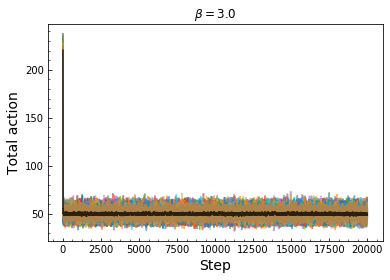

1

1

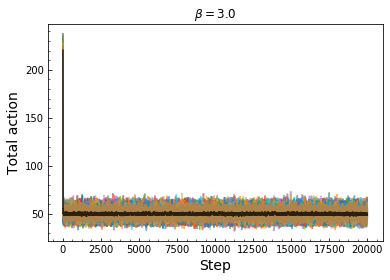

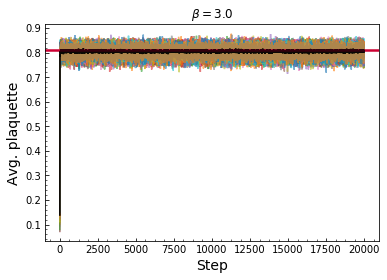

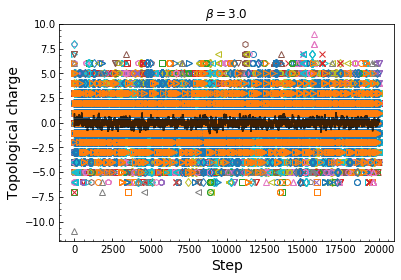

In [25]:
######################
# Total actions plots
######################
title_str = (r"$\beta = $"
             f"{beta}") # ", {len(steps)} eval steps")
kwargs = {
    'out_file': None,
    'markers': False,
    'lines': True,
    'alpha': 0.6,
    'title': title_str,
    'legend': False,
    'ret': False,
}
plot_multiple_lines(steps_arr, actions_arr.T, x_label='Step', y_label='Total action', **kwargs)

###########################
# Average plaquettes plots
###########################
kwargs['ret'] = True
_, ax = plot_multiple_lines(steps_arr, plaqs_arr.T, x_label='Step',
                            y_label='Avg. plaquette', **kwargs)

_ = ax.axhline(y=u1_plaq_exact(beta),
               color='#CC0033', ls='-', lw=2.5, label='exact')

_ = ax.plot(steps_arr, plaqs_arr.T.mean(axis=0),
            color='k', label='average', alpha=0.75)


############################
# Topological charge plots
############################
kwargs['markers'] = True
kwargs['lines'] = False
kwargs['alpha'] = 1.
kwargs['ret'] = False
plot_multiple_lines(steps_arr, charges_arr.T, x_label='Step',
                    y_label='Topological charge', **kwargs)

# OLD

## Calculate and plot observables...

### Calculate observables for samples generated **_during_** training:
- Every $\approx 500$ steps or so during training procedure, we run the sampler at $\beta \equiv \beta_{\mathrm{final}}$. 
- By calculating observables (``total action``, ``average plaquette``, and ``topological charge``) for these samples and looking at the ``thermalization time``, we can get an idea of how well the sampler is performing.
- We expect that as the training procedure continues, the ``thermalization time`` should decrease as the sampler improves.

In [ ]:
# 53.3s
plt.close('all')
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'run_233')
train_observables_dicts = calc_observables(log_dir,
                                           observables_dicts=None,
                                           training=True,
                                           frac=None)

In [ ]:
x = np.array([1., 1., 1., -1., -1., -1., 2., -2., 0., 0., 0., -2.])
y = np.array([0., 2., -1., -2., 0., 1., 0., 2., -2., 2., 1., -2.])

In [ ]:
len(x)

In [ ]:
c1 = np.sqrt(np.sum((x - y))**2)
c1

In [ ]:
c2 = np.sum(np.abs(x-y))
c2

In [ ]:
np.where(x != y)[0]

In [ ]:
len(np.where(x != y)[0])

In [ ]:
def tot_diff(x, y):
    z = np.where(x != y)[0]
    return np.sum([x[i] - y[i] if x[i] > y[i] else y[i] - x[i] for i in z])

In [ ]:
def tot_diff1(x, y):
    return np.sum(np.abs(x-y))

In [ ]:
xx = np.random.randint(-2, 2, size=1000)
yy = np.random.randint(-2, 2, size=1000)

In [ ]:
i = np.random.randint(-2, 2, size=10)
j = np.random.randint(-2, 2, size=10)

In [ ]:
def tot_diff2(x, y):
    return len(np.where(x != y)[0])

In [ ]:
tf.reduce_sum(i - j)

In [ ]:
tot_diff1(xx, yy)

In [ ]:
samples2 = tf.random_normal(samples.shape, dtype=tf.float32)

In [ ]:
samples = tf.cast(samples, dtype=tf.float32)

In [ ]:
samples = tf.reshape(samples, shape=(5, -1))
samples2 = tf.reshape(samples2, shape=(5, -1))
samples.shape, samples2.shape

In [ ]:
diff = tf.cast(i - j, dtype=tf.float32)

In [ ]:
loss_ = (tf.reduce_sum(1. - tf.cos(samples - samples2), axis=1)
          + tf.reduce_sum(diff))

In [ ]:
loss_

In [ ]:
loss_.shape

In [ ]:
u1_plaq_exact(4.)

In [ ]:
(i - j).shape

In [ ]:
ca = []
ca.append(i)
ca.append(j)
tot_diff1(ca[-1], ca[-2])
tot_diff2(ca[-1], ca[-2])

In [ ]:
charges_arr.extend(xx)

In [ ]:
u1_plaq_exact(2.05)

In [ ]:
char

In [ ]:
%timeit d = tot_diff(xx, yy)

In [ ]:
%timeit d1 = tot_diff1(xx, yy)

In [ ]:
tot_diff(xx, yy)

In [ ]:
tot_diff1(xx, yy)

####  Update train_observables_dicts:  
 * If `observables_dicts` argument of `calc_training_observables` is not `None`, only calculate observables that haven't been previously calculated.  

In [ ]:
train_observables_dicts = calc_observables(
    log_dir, 
    observables_dicts=train_observables_dicts,
    training=True,
)

#### Plot observables for samples generated **_during_** training:
- In addition, for each batch of samples generated during, plot the topological charge history of each individual chain in the batch.

In [ ]:
figs_axes = plot_observables(log_dir, train_observables_dicts, training=True)

In [ ]:
plot_top_charges(log_dir, train_observables_dicts[2], training=True)

In [ ]:
plot_top_charges_counts(log_dir,  train_observables_dicts[2],  training=True)

##### Plot top charges counts totaled over all samples

In [ ]:
train_charges_dict = train_observables_dicts[2]
params, _, _, _, figs_dir_dict = find_samples(log_dir, training=True)
title_str_key = 'training'
count_dict = {}
idx = 0
for key, val in train_charges_dict.items():
    step, beta = key
    counts = Counter(list(val.flatten()))
    count_dict[key] = counts
    fig, ax = plt.subplots()
    _ = ax.plot(list(counts.keys()), list(counts.values()), 
                color=COLORS[idx], marker=MARKERS[idx], ls='')
                #fillstyle='none')#, label=f'{key} training steps')
    idx += 1
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Number of occurrences', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{beta}, "
                 + f"{step} {title_str_key} steps; "
                 + f"total across {params['num_samples']} samples")
    _ = ax.set_title(title_str, fontsize=14)
    out_dir = os.path.join(
        figs_dir_dict[key], 'topological_charges_counts'
    )
    check_else_make_dir(out_dir)
    out_file = os.path.join(
        out_dir,
        f'topological_charge_counts_total_{step}_steps_beta_{beta}.pdf'
    )
    #if not os.path.isfile(out_file):
    print(f"Saving figure to {out_file}.")
    _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')

### Calculate observables for samples generated **_after_** training.
 - Again, samples are generated at $\beta = \beta_{\mathrm{final}}$.
 - In contrast to the samples generated **_during_** training (which are all ran for $\sim 100$ steps), we now look at generating longer chains (i.e. longer runs).

In [ ]:
plt.close('all')
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'run_227')
observables_dicts = calc_observables(log_dir, 
                                     observables_dicts=None, 
                                     training=False,
                                     frac=4)

In [ ]:
observables_dicts = calc_observables(log_dir, 
                                     observables_dicts=observables_dicts, 
                                     training=False,
                                     frac=4)

#### Plot observables for samples generated **_after_** training:
- In addition, for each batch of samples generated during, plot the topological charge history of each individual chain in the batch.

In [ ]:
figs_axes = plot_observables(log_dir, train_observables_dicts, training=False)

In [ ]:
plot_top_charges(log_dir, train_observables_dicts[2], training=False)

In [ ]:
plot_top_charges_counts(log_dir,  train_observables_dicts[2],  training=False)

##### Plot top charges counts totaled over all samples


In [ ]:
plt.close('all')
COLORS *= 10
MARKERS *= 10
params, _, _, _, figs_dir_dict = find_samples(log_dir)
charges_dict = observables_dicts[2]
title_str_key = 'evaluation'
count_dict = {}
idx = 0
for key, val in charges_dict.items():
    step, beta = key 
    counts = Counter(list(val.flatten()))
    count_dict[key] = counts
    fig, ax = plt.subplots()
    _ = ax.plot(list(counts.keys()), list(counts.values()), 
                color=COLORS[idx], marker=MARKERS[idx], ls='',
                fillstyle='full')#, label=f'{key} training steps')
    idx += 1
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Number of occurrences', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{beta}, "
                 + f"{step} steps; "
                 + f"total across {params['num_samples']} samples")
    _ = ax.set_title(title_str, fontsize=16)
    #out_dir = os.path.join(
    #    figs_dir_dict[key], 'topological_charges_counts'
    #)
    #check_else_make_dir(out_dir)
    out_file = os.path.join(
       figs_dir_dict[key],
        f'topological_charge_counts_total_{step}_steps_beta_{beta}.pdf'
    )
    #if not os.path.isfile(out_file):
    print(f"Saving figure to {out_file}.")
    _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.show()
    plt.close('all')